# Hybrid Multipath Reconstruction - Train

- Multi-channel data
- This notebooks is heavely inspired by flat_unrolled_cascade_train_mc.ipynb notebook available here: https://github.com/rmsouza01/CD-Deep-Cascade-MR-Reconstruction/blob/master/JNotebooks/flat_unrolled_cascade_train_mc.ipynb

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os
import glob
import sys
from scipy.io import loadmat
# Importing our model
MY_UTILS_PATH = "../src/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import hybrid_multipath_model as fsnet

# Importing callbacks and data augmentation utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from data_generator import DataGenerator
from keras.optimizers import  Adam

/home/alexandre/miniconda3/envs/venturus_keras/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alexandre/miniconda3/envs/venturus_keras/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alexandre/miniconda3/envs/venturus_keras/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alex

(100, 218, 170)
Undersampling: 0.8013043712898004
Mask type: bool
(100, 218, 170)


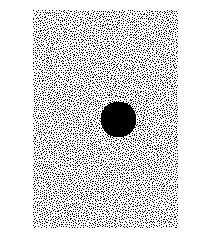

In [2]:
## PARAMETERS
H,W = 218,170 # Training image dimensions
channels = 24 # complex data 0-> real; 1-> imaginary
norm = np.sqrt(H*W)
batch_size = 5
# undersampling patterns - centered k-space - 100 pre computed patterns
var_sampling_mask = ~np.load("../Data/Sampling-patterns/218x170/poisson_center_radius=18_20perc.npy")
print(var_sampling_mask.shape)

print("Undersampling:", 1.0*var_sampling_mask.sum()/var_sampling_mask.size)
print("Mask type:",  var_sampling_mask.dtype)
print(var_sampling_mask.shape)
plt.figure()
plt.imshow(var_sampling_mask[0],cmap = "gray")
plt.axis("off")
plt.show()

In [3]:
# Train Set 
train_path = "<CHANGE TO YOUR TRAINING PATH>"
kspace_files_train = np.asarray(glob.glob(train_path))
indexes = np.arange(kspace_files_train.shape[0],dtype = int)
np.random.shuffle(indexes)
kspace_files_train = kspace_files_train[indexes]

# Validation set
val_path = "<CHANGE TO YOUR VALIDATION PATH>"
kspace_files_val = np.asarray(glob.glob(val_path))
indexes = np.arange(kspace_files_val.shape[0],dtype = int)
np.random.shuffle(indexes)
kspace_files_val = kspace_files_val[indexes]

print(kspace_files_train[-1])
print(len(kspace_files_train))

print(kspace_files_val[-1])
print(len(kspace_files_val))

var_sampling_mask = var_sampling_mask[:,:,:,np.newaxis]
var_sampling_mask = np.tile(var_sampling_mask,(1,1,1,24))
print(var_sampling_mask.shape)
train_generator = DataGenerator(kspace_files_train,var_sampling_mask,norm,batch_size=8)
val_generator = DataGenerator(kspace_files_val,var_sampling_mask,norm,batch_size=8)

/home/ubuntu/volume1/Slices/Train-mc/e14498s5_P60928.7_image_slice138.jpg.npy
10240
/home/ubuntu/volume1/Slices/Val-mc/e14258s3_P76800.7_image_slice103.jpg.npy
2560
(100, 218, 170, 24)


## Model Parameters

In [5]:
epochs = 50
#choose batch size as much as possible. 
batch_size= 8
earlyStopping = EarlyStopping(monitor='val_loss',
                                           patience=5, 
                                           verbose=0, mode='min')

In [ ]:
model_name = "../models/hmrc.hdf5"
print(model_name)
    
# Checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                             monitor='val_loss',verbose=0,\
                             save_best_only=True, save_weights_only = True)

model = fsnet.deep_hybrid_multipath(H=218, W=170)
opt = Adam(lr = 1e-3)
model.compile(loss = fsnet.nrmse_min_max,optimizer=opt)

hist = model.fit_generator(train_generator,
                               epochs=epochs,
                               steps_per_epoch=kspace_files_train.size//batch_size,
                               verbose=1,
                               validation_data= val_generator,
                               callbacks=[checkpoint,earlyStopping])

../Models/flat_unrolled_cascade_ikikii_mc.hdf5
Instructions for updating:
Colocations handled automatically by placer.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Instructions for updating:
Use tf.cast instead.
Epoch 1/30
  98/1280 [=>............................] - ETA: 33:31 - loss: 0.3769